# [SfN] Train m=8

_Etienne Ackermann, 08/05/2015_

The data can be downloaded from the [CRCNS](http://crcns.org/data-sets/hc/hc-3) (Collaborative Research in Computational Neuroscience) website, and the ```hc-3``` data set in particular.

### Summary

Note that both **gor01** and **vvp01** were recorded with a Neuralynx recording system at 32,552 Hz, then amplified 1000x, followed by 1–5 kHz bandpass filtering. It was then further downsampled to 1252 Hz, and stored in the .eeg file, which is a binary file with the same number of channels as in the raw data.  Has up to 32 (four shank probe) or 64 (eight shank probe) short integers (2 bytes, signed) every time step.  (One integer from each recording site, i.e. channel).  Actual number of channels is specified in the .xml file and is not always a multiple of 8 because bad channels (due to very high impedance or broken shank) were removed from the data. 

---

## Load observation data

At this point we are interested in learning from the data, and we do this by considering sequences of spike count observations. That is, each observation is a $u$-dimensional vector, where $u$ is the number of units that we recorded, with each element corresponds to the number of spikes observed within a time bin of 250 or 10 ms, depending on whether we are considering the behavioral, or the replay timescales.

In [104]:
import pickle

# load SWR spikes for both environments (binned in 10 ms):
with open('../../Data/SWR_train1rn.pickle', 'rb') as f:
    SWR_train1 = pickle.load(f)
with open('../../Data/SWR_train2rn.pickle', 'rb') as f:
    SWR_train2 = pickle.load(f)
    
with open('../../Data/SWR_test1rn.pickle', 'rb') as f:
    SWR_test1 = pickle.load(f)
with open('../../Data/SWR_test2rn.pickle', 'rb') as f:
    SWR_test2 = pickle.load(f)
    
# load training spike count data, binned in 250 ms bins:
with open('../../Data/BVR_train1rn_noswr_noth1.pickle', 'rb') as f:
    BVR_train1 = pickle.load(f)
with open('../../Data/BVR_train2rn_noswr_th1.pickle', 'rb') as f:
    BVR_train2 = pickle.load(f)    
    
# load testing spike count data, binned in 250 ms bins:
with open('../../Data/BVR_test1rn_noswr_noth1.pickle', 'rb') as f:
    BVR_test1 = pickle.load(f)  
with open('../../Data/BVR_test2rn_noswr_th1.pickle', 'rb') as f:
    BVR_test2 = pickle.load(f)

## Load Python modules and helper functions

In [2]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import pickle 
import seaborn as sns
import yahmm as ym

from matplotlib import pyplot as plt
from pandas import Series, DataFrame

from efunctions import * # load my helper functions

%matplotlib inline

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


## Train HMMs on SWR-spike observations


**WARNING!!** For some reason, my make-n-bake function does not seem to be adding either the states correctly, or the transitions. So when I bake it, all my states get orphaned and cut off... What's going on!!? Fixed it now! Python can be strange when it comes to passing and returning immutable (and mutable!) types... :/

In [3]:
import random
eps = 0.001

def make_n_bake_yahmm_model(ymModel, num_cells, num_states=15, verbose=False):
    
    mymodel = ymModel
    
    states_list = []
    
    # create list of states:
    for ss in np.arange(0,num_states):
        states_list.append(ym.State( ym.MultivariateDistribution( [ym.PoissonDistribution( random.random() + eps ) for c in range(num_cells) ] ) ))
    
    mymodel.add_states( states_list )
    
    # add transition probabilities:
    
    mymodel.add_transitions(mymodel.start, states_list, [0.1] * num_states )
    for ss in np.arange(0,num_states):
        mymodel.add_transitions(states_list[ss], states_list, [ random.random() + eps for r in np.arange(num_states)] )
    
    mymodel.bake( verbose=verbose )
    return mymodel

num_cells = len( SWR_train1[0][0] )

#swrhmm8_2 = ym.Model(name="SWR-HMM_8_2")
swrhmm8_1 = make_n_bake_yahmm_model(ym.Model(name="SWR-HMM_8_1"), num_cells, num_states=8)
swrhmm8_2 = make_n_bake_yahmm_model(ym.Model(name="SWR-HMM_8_2"), num_cells, num_states=8)
swrhmm15_1 = make_n_bake_yahmm_model(ym.Model(name="SWR-HMM_15_1"), num_cells, num_states=15)
swrhmm15_2 = make_n_bake_yahmm_model(ym.Model(name="SWR-HMM_15_2"), num_cells, num_states=15)
swrhmm10_1 = make_n_bake_yahmm_model(ym.Model(name="SWR-HMM_10_1"), num_cells, num_states=10)
swrhmm10_2 = make_n_bake_yahmm_model(ym.Model(name="SWR-HMM_10_2"), num_cells, num_states=10)

hmm8_1 = make_n_bake_yahmm_model(ym.Model(name="HMM_8_1"), num_cells, num_states=8)
hmm8_2 = make_n_bake_yahmm_model(ym.Model(name="HMM_8_2"), num_cells, num_states=8)
hmm15_1 = make_n_bake_yahmm_model(ym.Model(name="HMM_15_1"), num_cells, num_states=15)
hmm15_2 = make_n_bake_yahmm_model(ym.Model(name="HMM_15_2"), num_cells, num_states=15)
hmm10_1 = make_n_bake_yahmm_model(ym.Model(name="HMM_10_1"), num_cells, num_states=10)
hmm10_2 = make_n_bake_yahmm_model(ym.Model(name="HMM_10_2"), num_cells, num_states=10)

## Train models

In [4]:
def train_hmm(ymModel,train,num_sequences):
    ymModel.train(train[:num_sequences],algorithm='baum-welch', verbose=True)
    return ymModel

hmm8_1 = train_hmm(hmm8_1,BVR_train1,num_sequences=80)
hmm8_2 = train_hmm(hmm8_2,BVR_train2,num_sequences=80)
swrhmm8_1 = train_hmm(swrhmm8_1,SWR_train1,num_sequences=80)
swrhmm8_2 = train_hmm(swrhmm8_2,SWR_train2,num_sequences=80)

Training improvement: 854.5186714722519
Training improvement: 10.200636130307942
Training improvement: -1.961263190690488
('Total Training Improvement: ', 862.7580444118694)
Training improvement: 311.90215063064386
Training improvement: 48.01855724153893
Training improvement: 9.241248416526332
Training improvement: 2.534021590154225
Training improvement: 0.9391272173896823
Training improvement: 1.094257843380717
Training improvement: 2.1053457890922687
Training improvement: 2.4597117362769723
Training improvement: 0.5352147324167049
Training improvement: 0.08621232849947091
Training improvement: 0.2531288499446873
Training improvement: 0.29563027136902065
Training improvement: -0.31295272439120936
('Total Training Improvement: ', 379.15165392284166)
Training improvement: 160.62220531943635
Training improvement: 2.2979824150606376
Training improvement: 1.2898025232255002
Training improvement: 0.16818104337959028
Training improvement: -0.0951309596713088
('Total Training Improvement: ', 

In [105]:
hmm8_1 = train_hmm(hmm8_1,BVR_train1,num_sequences=80)

Training improvement: 28.23704022029773
Training improvement: 1.269475050203198

Exception ignored in: 'yahmm.yahmm.Model._train_once_baum_welch'
Traceback (most recent call last):
  File "yahmm/yahmm.pyx", line 2938, in yahmm.yahmm.Model.forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45281)
  File "yahmm/yahmm.pyx", line 2969, in yahmm.yahmm.Model._forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45799)
  File "yahmm/yahmm.pyx", line 1998, in yahmm.yahmm.MultivariateDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31326)
  File "yahmm/yahmm.pyx", line 1998, in genexpr (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31223)
  File "yahmm/yahmm.pyx", line 551, in yahmm.yahmm.PoissonDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:9910)
  File "/home/etienne/anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py", line 2861, in logpmf
    goodargs = argsreduce(cond, *((k,)+args))
  File "/home/


Training improvement: 288.53174930868204

'yahmm.yahmm.Model._log_probability'
Traceback (most recent call last):
  File "yahmm/yahmm.pyx", line 2938, in yahmm.yahmm.Model.forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45281)
  File "yahmm/yahmm.pyx", line 2969, in yahmm.yahmm.Model._forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45799)
  File "yahmm/yahmm.pyx", line 1998, in yahmm.yahmm.MultivariateDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31326)
  File "yahmm/yahmm.pyx", line 1998, in genexpr (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31223)
  File "yahmm/yahmm.pyx", line 551, in yahmm.yahmm.PoissonDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:9910)
  File "/home/etienne/anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py", line 2862, in logpmf
    place(output, cond, self._logpmf(*goodargs))
  File "/home/etienne/anaconda3/lib/pyt


Training improvement: 0.0

'yahmm.yahmm.Model._log_probability'
Traceback (most recent call last):
  File "yahmm/yahmm.pyx", line 2938, in yahmm.yahmm.Model.forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45281)
  File "yahmm/yahmm.pyx", line 2969, in yahmm.yahmm.Model._forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45799)
  File "yahmm/yahmm.pyx", line 1998, in yahmm.yahmm.MultivariateDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31326)
  File "yahmm/yahmm.pyx", line 1998, in genexpr (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31223)
  File "yahmm/yahmm.pyx", line 551, in yahmm.yahmm.PoissonDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:9910)
  File "/home/etienne/anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py", line 2861, in logpmf
    goodargs = argsreduce(cond, *((k,)+args))
  File "/home/etienne/anaconda3/lib/python


('Total Training Improvement: ', 317.9429543993786)


'yahmm.yahmm.Model._log_probability'
Traceback (most recent call last):
  File "yahmm/yahmm.pyx", line 2938, in yahmm.yahmm.Model.forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45281)
  File "yahmm/yahmm.pyx", line 2969, in yahmm.yahmm.Model._forward (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:45799)
  File "yahmm/yahmm.pyx", line 1998, in yahmm.yahmm.MultivariateDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31326)
  File "yahmm/yahmm.pyx", line 1998, in genexpr (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:31223)
  File "yahmm/yahmm.pyx", line 551, in yahmm.yahmm.PoissonDistribution.log_probability (/home/etienne/.pyxbld/temp.linux-x86_64-3.4/pyrex/yahmm/yahmm.c:9910)
  File "/home/etienne/anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py", line 2861, in logpmf
    goodargs = argsreduce(cond, *((k,)+args))
  File "/home/etienne/anaconda3/lib/python

In [ ]:
#num_sequences = len(SWR_train1)
num_sequences = 80

#before_training_log_prob = [ swrhmm8_1.log_probability( SWR_train1[a] ) for a in range(len(SWR_train1[:num_sequences])) ]
#print( 'average log probability of sequences BEFORE training: ' + str( np.average(before_training_log_prob) ) )

swrhmm8_1.train( SWR_train1[:num_sequences], algorithm='baum-welch', verbose=True )

#after_training_log_prob = [ swrhmm8_1.log_probability( SWR_train1[a] ) for a in range(len(SWR_train1[:num_sequences])) ]
#print( 'average log probability of sequences AFTER training: ' + str( np.average(after_training_log_prob) ) )


In [ ]:
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot( before_training_log_prob, bins=20, hist=True, kde=True, rug=False, axlabel='log probability', ax=ax1 );
sns.distplot( after_training_log_prob, bins=20, hist=True, kde=True, rug=False, axlabel='log probability', ax=ax2 );

ax1.set_title("Before training")
ax2.set_title("After training")
plt.suptitle("Effect of training on SWR-spike events, m={0}; swr-hmm8-1".format(num_states), y=1.05, fontsize=16)

plt.tight_layout()

#saveFigure("figures/swr-hmm8-1rn-training.pdf")


Train SWR-HMM8_2 on a small subset of the training data:

In [ ]:
num_sequences = 80
#num_sequences = len(SWR_train2)

#before_training_log_prob = [ swrhmm8_2.log_probability( SWR_train2[a] ) for a in range(len(SWR_train2[:num_sequences])) ]
#print( 'average log probability of sequences BEFORE training: ' + str( np.average(before_training_log_prob) ) )

swrhmm8_2.train( SWR_train2[:num_sequences], algorithm='baum-welch', verbose=True )

#after_training_log_prob = [ swrhmm8_2.log_probability( SWR_train2[a] ) for a in range(len(SWR_train2[:num_sequences])) ]
#print( 'average log probability of sequences AFTER training: ' + str( np.average(after_training_log_prob) ) )


## Train m=8, m=10 and m=15 state models on subset of sequences:

In [ ]:
num_sequences = 80

hmm8_1.train( BVR_train1[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
hmm8_2.train( BVR_train2[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
swrhmm8_1.train( SWR_train1[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
swrhmm8_2.train( SWR_train2[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
hmm10_1.train( BVR_train1[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
hmm10_2.train( BVR_train2[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
swrhmm10_1.train( SWR_train1[:num_sequences], algorithm='baum-welch', verbose=True )

In [ ]:
swrhmm10_2.train( SWR_train2[:num_sequences], algorithm='baum-welch', verbose=True )

## Investigate a few things on the trained model...

* Look at the state transition probability matrix (but it seems like YAHMM does not report this correctly...?)
* Look to see if we can infer the most likely sequence of states for a particular sequence
* Look to see if the log-probability of the sequence in (2) changes if we shuffle the observations, which would give us confidence that the model has at least captured **some** sequential information from the data
* Look at the tuning curves (or firing rates) of the different states---this does not seem trivial with YAHMM

In [ ]:
hmm8_1.dense_transition_matrix().shape

In [ ]:
# find the log probability of the "best" length N sequence:
def best_state_sequence(ymModel,Nstates):
    logP = ymModel.dense_transition_matrix()
    N = Nstates
    
    statelist = [ymModel.start_index]
    logPij = [np.log(1 / (ymModel.state_count() - 2)) ] # assume each starting location equally likely
    for ii in np.arange(0,N):
        nextstate = list(logP[statelist[-1],:]).index(max(logP[statelist[-1],:]))
        statelist.append(nextstate)
        logPij.append(logP[statelist[-2],statelist[-1]])

    lpbest = np.array(logPij).sum()
    
    return lpbest, statelist, logPij

In [ ]:
lpbest, statelist, Pij = best_state_sequence(hmm15_1,5)
lpbest

In [ ]:
import copy
cand_seq = copy.deepcopy(BVR_train1[0])
lp, mlse_pth = hmm8_1.viterbi(cand_seq)
lp

In [ ]:
mlse_pth

In [ ]:
shuffled_seq = copy.deepcopy(cand_seq)
random.shuffle(shuffled_seq)
lp_shfl, mlse_pth_shfl = hmm8_1.viterbi(shuffled_seq)

In [ ]:
[lp, lp_shfl] # shows that sequence DOES matter!

In [ ]:
mlse_pth_shfl

In [6]:
# Random sequence of lengh L through model, along with log-prob:
seq, pth = hmm8_1.sample(length=len(cand_seq), path=True)
lprand, pth_best = hmm8_1.viterbi(seq)
lprand

NameError: name 'cand_seq' is not defined

In [ ]:
# "Best" sequence of lengh L through model, along with log-prob:
lpbest, statelist, Pij = best_state_sequence(hmm8_1,len(seq))
lpbest

In [5]:
print(hmm8_1.states[1])

State( MultivariateDistribution(<map object at 0x7f7a05d2c940>), name=140163190718592, weight=1.0, identity=140162124974984 )


## Continue analysis here

In [10]:
num_sequences = 60
seq1_in_model1_log_prob_test = [ hmm8_1.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]
seq2_in_model2_log_prob_test = [ hmm8_2.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
seq2_in_model1_log_prob_test = [ hmm8_1.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
seq1_in_model2_log_prob_test = [ hmm8_2.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]

# note: log odds = log(P1/P2) = logP1 - logP2:
seq2_ratio_test = [seq2_in_model1_log_prob_test[i] - seq2_in_model2_log_prob_test[i] for i in range(len(seq2_in_model1_log_prob_test)) ]
seq1_ratio_test = [seq1_in_model1_log_prob_test[i] - seq1_in_model2_log_prob_test[i] for i in range(len(seq1_in_model1_log_prob_test)) ]


Saving figure to 'figures/logodds-xross-swr-in-bvr-m8.pdf'...
Done


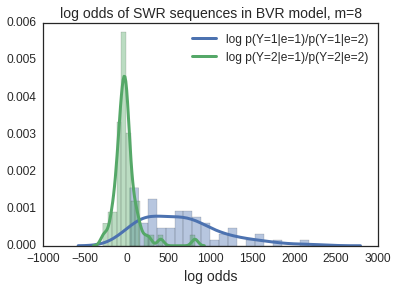

In [12]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( seq1_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)/p(Y=1|e=2)"} );
sns.distplot( seq2_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)/p(Y=2|e=2)"} );
ax1.set_title("log odds of SWR sequences in BVR model, m=8",fontsize=14)

#saveFigure("figures/logodds-xross-swr-in-bvr-m8.pdf")

In [43]:
num_sequences = 60
seq1_in_model1_log_prob_test = [ swrhmm8_1.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]
seq2_in_model2_log_prob_test = [ swrhmm8_2.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
seq2_in_model1_log_prob_test = [ swrhmm8_1.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
seq1_in_model2_log_prob_test = [ swrhmm8_2.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]

# note: log odds = log(P1/P2) = logP1 - logP2:
seq2_ratio_test = [seq2_in_model1_log_prob_test[i] - seq2_in_model2_log_prob_test[i] for i in range(len(seq2_in_model1_log_prob_test)) ]
seq1_ratio_test = [seq1_in_model1_log_prob_test[i] - seq1_in_model2_log_prob_test[i] for i in range(len(seq1_in_model1_log_prob_test)) ]


Saving figure to 'figures/logodds-swr-in-swr-m8-new.pdf'...
Done


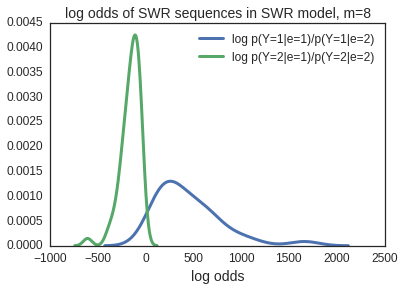

In [47]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( seq1_ratio_test, bins=20, hist=False, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)/p(Y=1|e=2)"} );
sns.distplot( seq2_ratio_test, bins=20, hist=False, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)/p(Y=2|e=2)"} );
ax1.set_title("log odds of SWR sequences in SWR model, m=8",fontsize=14)

#saveFigure("figures/logodds-swr-in-swr-m8-new.pdf")

In [9]:
num_sequences = 60
seq1_in_model1_log_prob_test = [ swrhmm8_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
seq2_in_model2_log_prob_test = [ swrhmm8_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
seq2_in_model1_log_prob_test = [ swrhmm8_1.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
seq1_in_model2_log_prob_test = [ swrhmm8_2.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]

seq2_ratio_test = [seq2_in_model1_log_prob_test[i] - seq2_in_model2_log_prob_test[i] for i in range(len(seq2_in_model1_log_prob_test)) ]
seq1_ratio_test = [seq1_in_model1_log_prob_test[i] - seq1_in_model2_log_prob_test[i] for i in range(len(seq1_in_model1_log_prob_test)) ]


In [ ]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( seq1_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)/p(Y=1|e=2)"} );
sns.distplot( seq2_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)/p(Y=2|e=2)"} );
ax1.set_title("log odds of BVR sequences in SWR model, m=8",fontsize=14)

#saveFigure("figures/logodds-xross-bvr-in-swr-m8.pdf")

In [ ]:
num_sequences = 60
seq1_in_model1_log_prob_test = [ swrhmm15_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
seq2_in_model2_log_prob_test = [ swrhmm15_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
seq2_in_model1_log_prob_test = [ swrhmm15_1.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
seq1_in_model2_log_prob_test = [ swrhmm15_2.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]

seq2_ratio_test = [seq2_in_model1_log_prob_test[i] - seq2_in_model2_log_prob_test[i] for i in range(len(seq2_in_model1_log_prob_test)) ]
seq1_ratio_test = [seq1_in_model1_log_prob_test[i] - seq1_in_model2_log_prob_test[i] for i in range(len(seq1_in_model1_log_prob_test)) ]


In [ ]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( seq1_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)/p(Y=1|e=2)"} );
sns.distplot( seq2_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)/p(Y=2|e=2)"} );
ax1.set_title("log odds of BVR sequences in SWR model, m=15",fontsize=14)

saveFigure("figures/logodds-xross-bvr-in-swr-m15.pdf")

## Look for SWR1 in ENV2 and SW2 in ENV1

In [13]:
num_sequences = 60
bvr1_in_bvr1_log_prob_test = [ hmm8_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
bvr2_in_bvr2_log_prob_test = [ hmm8_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr2_in_bvr1_log_prob_test = [ hmm8_1.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr1_in_bvr2_log_prob_test = [ hmm8_2.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]

num_sequences = 60
bvr1_in_swr1_log_prob_test = [ swrhmm8_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
bvr2_in_swr2_log_prob_test = [ swrhmm8_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr2_in_swr1_log_prob_test = [ swrhmm8_1.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr1_in_swr2_log_prob_test = [ swrhmm8_2.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]

num_sequences = 60
swr1_in_bvr1_log_prob_test = [ hmm8_1.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]
swr2_in_bvr2_log_prob_test = [ hmm8_2.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
swr2_in_bvr1_log_prob_test = [ hmm8_1.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
swr1_in_bvr2_log_prob_test = [ hmm8_2.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]

num_sequences = 60
swr1_in_swr1_log_prob_test = [ swrhmm8_1.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]
swr2_in_swr2_log_prob_test = [ swrhmm8_2.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
swr2_in_swr1_log_prob_test = [ swrhmm8_1.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
swr1_in_swr2_log_prob_test = [ swrhmm8_2.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]

# normalized versions:

#num_sequences = 60
#bvr1_in_bvr1_log_prob_test_nrm = [ hmm8_1.log_probability( BVR_test1[a] ) - best_state_sequence(hmm8_1,len(BVR_test1[0]))[0] for a in range(len(BVR_test1[:num_sequences])) ]
#bvr2_in_bvr2_log_prob_test_nrm = [ hmm8_2.log_probability( BVR_test2[a] ) - best_state_sequence(hmm8_2,len(BVR_test2[0]))[0] for a in range(len(BVR_test2[:num_sequences])) ]
#bvr2_in_bvr1_log_prob_test_nrm = [ hmm8_1.log_probability( BVR_test2[a] ) - best_state_sequence(hmm8_1,len(BVR_test2[0]))[0] for a in range(len(BVR_test2[:num_sequences])) ]
#bvr1_in_bvr2_log_prob_test_nrm = [ hmm8_2.log_probability( BVR_test1[a] ) - best_state_sequence(hmm8_2,len(BVR_test1[0]))[0] for a in range(len(BVR_test1[:num_sequences])) ]

#num_sequences = 60
#bvr1_in_swr1_log_prob_test_nrm = [ swrhmm8_1.log_probability( BVR_test1[a] ) - best_state_sequence(swrhmm8_1,len(BVR_test1[0]))[0] for a in range(len(BVR_test1[:num_sequences])) ]
#bvr2_in_swr2_log_prob_test_nrm = [ swrhmm8_2.log_probability( BVR_test2[a] ) - best_state_sequence(swrhmm8_2,len(BVR_test2[0]))[0] for a in range(len(BVR_test2[:num_sequences])) ]
#bvr2_in_swr1_log_prob_test_nrm = [ swrhmm8_1.log_probability( BVR_test2[a] ) - best_state_sequence(swrhmm8_1,len(BVR_test2[0]))[0] for a in range(len(BVR_test2[:num_sequences])) ]
#bvr1_in_swr2_log_prob_test_nrm = [ swrhmm8_2.log_probability( BVR_test1[a] ) - best_state_sequence(swrhmm8_2,len(BVR_test1[0]))[0] for a in range(len(BVR_test1[:num_sequences])) ]

#num_sequences = 60
#swr1_in_bvr1_log_prob_test_nrm = [ hmm8_1.log_probability( SWR_test1[a] ) - best_state_sequence(hmm8_1,len(SWR_test1[0]))[0] for a in range(len(SWR_test1[:num_sequences])) ]
#swr2_in_bvr2_log_prob_test_nrm = [ hmm8_2.log_probability( SWR_test2[a] ) - best_state_sequence(hmm8_2,len(SWR_test2[0]))[0] for a in range(len(SWR_test2[:num_sequences])) ]
#swr2_in_bvr1_log_prob_test_nrm = [ hmm8_1.log_probability( SWR_test2[a] ) - best_state_sequence(hmm8_1,len(SWR_test2[0]))[0] for a in range(len(SWR_test2[:num_sequences])) ]
#swr1_in_bvr2_log_prob_test_nrm = [ hmm8_2.log_probability( SWR_test1[a] ) - best_state_sequence(hmm8_2,len(SWR_test1[0]))[0] for a in range(len(SWR_test1[:num_sequences])) ]


Saving figure to 'figures/logprob-bvr-in-bvr-m8-new.pdf'...
Done


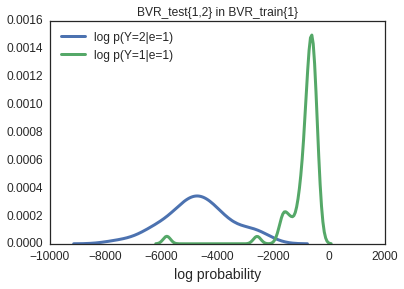

In [21]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1) = plt.subplots(1,1)

sns.distplot( bvr2_in_bvr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)"}  );
#sns.distplot( bvr1_in_bvr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax2, kde_kws={"lw": 3, "label": "log p(Y=1|e=2)"} );
sns.distplot( bvr1_in_bvr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)"} );
#sns.distplot( bvr2_in_bvr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax2, kde_kws={"lw": 3, "label": "log p(Y=2|e=2)"} );

ax1.set_title('BVR_test{1,2} in BVR_train{1}')
#ax2.set_title('BVR_test{1,2} in BVR_train{2}')

#ax2.set_xlim([-20000, 0])

#saveFigure("figures/logprob-bvr-in-bvr-m8-new.pdf")

Saving figure to 'figures/logprob-swr-in-bvr2-m8-new.pdf'...
Done


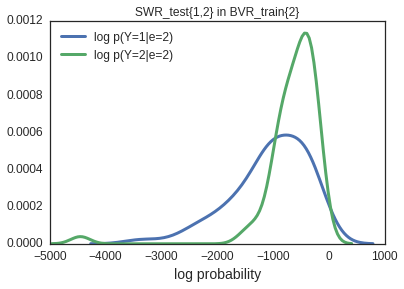

In [115]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

#sns.distplot( swr2_in_bvr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)"}  );
sns.distplot( swr1_in_bvr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=2)"} );
#sns.distplot( swr1_in_bvr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)"} );
sns.distplot( swr2_in_bvr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=2)"} );

ax1.set_title('SWR_test{1,2} in BVR_train{2}')
#ax2.set_title('SWR_test{1,2} in BVR_train{2}')

saveFigure("figures/logprob-swr-in-bvr2-m8-new.pdf")

Saving figure to 'figures/logprob-bvr-in-swr-m8-new.pdf'...
Done


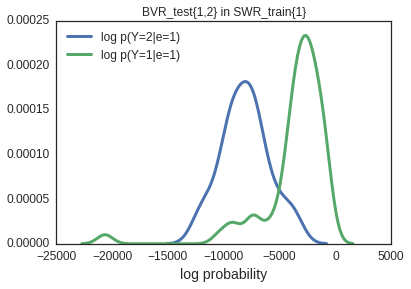

In [25]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1) = plt.subplots(1)

sns.distplot( bvr2_in_swr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)"}  );
#sns.distplot( bvr1_in_swr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax2, kde_kws={"lw": 3, "label": "log p(Y=1|e=2)"} );
sns.distplot( bvr1_in_swr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)"} );
#sns.distplot( bvr2_in_swr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax2, kde_kws={"lw": 3, "label": "log p(Y=2|e=2)"} );

ax1.set_title('BVR_test{1,2} in SWR_train{1}')
#ax2.set_title('BVR_test{1,2} in SWR_train{2}')

#saveFigure("figures/logprob-bvr-in-swr-m8-new.pdf")


In [ ]:

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1, ax2 ) = plt.subplots(1,2)

sns.distplot( swr2_in_swr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=2|e=1)"}  );
sns.distplot( swr1_in_swr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax2, kde_kws={"lw": 3, "label": "log p(Y=1|e=2)"} );
sns.distplot( swr1_in_swr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p(Y=1|e=1)"} );
sns.distplot( swr2_in_swr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax2, kde_kws={"lw": 3, "label": "log p(Y=2|e=2)"} );

ax1.set_title('SWR_test{1,2} in SWR_train{1}')
ax2.set_title('SWR_test{1,2} in SWR_train{2}')

#saveFigure("figures/logprob-swr-in-swr-m8.pdf")

## Shuffle bins in observation sequences and evaluate in models:

We would **hope** that if we shuffle observations in a sequence, that the observation sequence would no longer be consistent with the HMM. However, one thing to keep in mind is that if we have really short sequences, or if we have sequences where the animal hardly changed states, then such a shuffling strategy would not lead to any meaningful difference in the log-probability of the sequence in the HMM.

In [141]:
import copy
shuffled_swr2_test = copy.deepcopy(SWR_test2) # make a copy of the bvr test data for LinearOne


In [142]:
shuffle(shuffled_swr2_test[0])
hmm8_2.log_probability(shuffled_swr2_test[0])


-4515.402559021384

In [ ]:
from random import shuffle

# for each sequence, shuffle the observations (the bins)
for ll in np.arange(0,len(shuffled_bvr1_test)):
    shuffle(shuffled_bvr1_test[ll])

# for each sequence, shuffle the observations (the bins)
for ll in np.arange(0,len(shuffled_bvr2_test)):
    shuffle(shuffled_bvr2_test[ll])

In [151]:
seq = SWR_test2[49]
sseq = copy.deepcopy(seq)
print('seq len: {0}'.format(len(seq)))
shufflplist = []
for ii in np.arange(0,30):
    shuffle(sseq)
    shufflplist.append(hmm8_1.log_probability( sseq ))



seq len: 13


In [152]:
shufflplist2 = []
for ii in np.arange(0,30):
    shuffle(sseq)
    shufflplist2.append(hmm8_2.log_probability( sseq ))


In [157]:
hmm8_2.log_probability(SWR_test2[49])

-706.4061762546936

In [156]:
hmm8_1.log_probability(SWR_test2[49])

-365.2141069443752

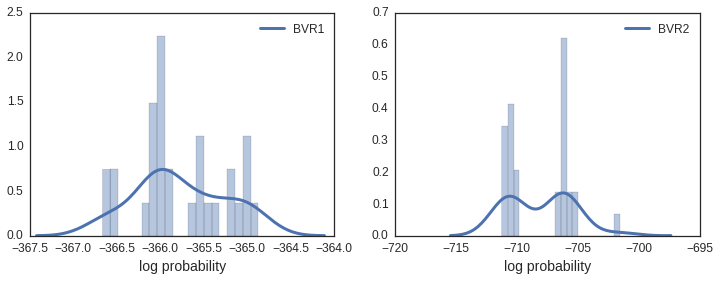

In [155]:
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1, ax2 ) = plt.subplots(1,2)

sns.distplot( shufflplist, bins=20, hist=True, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1"}  );
sns.distplot( shufflplist2, bins=20, hist=True, kde=True, rug=False, ax=ax2, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR2"}  );

#saveFigure("figures/shuffled-bvr1.pdf")

In [ ]:
num_sequences = 60
bvr1_in_bvr1_log_prob_test_m15 = [ hmm15_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
bvr1_shuffled_in_bvr1_log_prob_test_m15 = [ hmm15_1.log_probability( shuffled_bvr1_test[a] ) for a in range(len(shuffled_bvr1_test[:num_sequences])) ]
bvr2_in_bvr2_log_prob_test_m15 = [ hmm15_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr2_shuffled_in_bvr2_log_prob_test_m15 = [ hmm15_2.log_probability( shuffled_bvr2_test[a] ) for a in range(len(shuffled_bvr2_test[:num_sequences])) ]

bvr1_in_bvr1_log_prob_test_m8 = [ hmm8_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
bvr1_shuffled_in_bvr1_log_prob_test_m8 = [ hmm8_1.log_probability( shuffled_bvr1_test[a] ) for a in range(len(shuffled_bvr1_test[:num_sequences])) ]
bvr2_in_bvr2_log_prob_test_m8 = [ hmm8_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr2_shuffled_in_bvr2_log_prob_test_m8 = [ hmm8_2.log_probability( shuffled_bvr2_test[a] ) for a in range(len(shuffled_bvr2_test[:num_sequences])) ]

In [ ]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( bvr1_in_bvr1_log_prob_test_m8, bins=20, hist=True, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1_test"}  );
sns.distplot( bvr1_shuffled_in_bvr1_log_prob_test_m8, bins=20, hist=True, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1_test_shuffled"} );

#sns.distplot( seq1_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(e=1|Y=2)/p(e=2|Y=2)"} );
#sns.distplot( seq2_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(e=1|Y=1)/p(e=2|Y=1)"} );
ax1.set_title("Shuffled test, m=8",fontsize=14)

#saveFigure("figures/shuffled-bvr1.pdf")

## Now repeat shuffle analysis for "pseudo-normalized" sequences

In [ ]:
# Random sequence of lengh L through model, along with log-prob:
#seq = hmm15_1.sample(length=len(cand_seq))
hmm15_1.viterbi(hmm15_1.sample(length=len(cand_seq)))[0]


In [ ]:
num_sequences = 60
bvr1_in_bvr1_log_prob_test = [ hmm15_1.log_probability( BVR_test1[a] ) - hmm15_1.viterbi(hmm15_1.sample(length=len(BVR_test1[a])))[0] for a in range(len(BVR_test1[:num_sequences])) ]
bvr1_shuffled_in_bvr1_log_prob_test = [ hmm15_1.log_probability( shuffled_bvr1_test[a] ) - hmm15_1.viterbi(hmm15_1.sample(length=len(BVR_test1[a])))[0] for a in range(len(shuffled_bvr1_test[:num_sequences])) ]

In [ ]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( bvr1_in_bvr1_log_prob_test, bins=20, hist=True, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1_test"}  );
sns.distplot( bvr1_shuffled_in_bvr1_log_prob_test, bins=20, hist=True, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1_test_shuffled"} );

#sns.distplot( seq1_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(e=1|Y=2)/p(e=2|Y=2)"} );
#sns.distplot( seq2_ratio_test, bins=20, hist=True, kde=True, axlabel='log odds', ax=ax1, kde_kws={"lw": 3, "label": "log p(e=1|Y=1)/p(e=2|Y=1)"} );
ax1.set_title("Shuffled test w pseudo-normalized sequences",fontsize=14)

#saveFigure("figures/shuffled-bvr1-normalized.pdf")

In [26]:
import copy
shuffled_bvr1_test = copy.deepcopy(BVR_test1) # make a copy of the bvr test data for LinearOne
shuffled_bvr2_test = copy.deepcopy(BVR_test2) # make a copy of the bvr test data for LinearTwo


In [27]:
from random import shuffle

# for each sequence, shuffle the observations (the bins)
for ll in np.arange(0,len(shuffled_bvr1_test)):
    shuffle(shuffled_bvr1_test[ll])

# for each sequence, shuffle the observations (the bins)
for ll in np.arange(0,len(shuffled_bvr2_test)):
    shuffle(shuffled_bvr2_test[ll])

In [28]:
num_sequences = 60
#bvr1_in_bvr1_log_prob_test_m10 = [ hmm10_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
#bvr1_shuffled_in_bvr1_log_prob_test_m10 = [ hmm10_1.log_probability( shuffled_bvr1_test[a] ) for a in range(len(shuffled_bvr1_test[:num_sequences])) ]
bvr2_in_bvr2_log_prob_test_m8 = [ hmm8_2.log_probability( BVR_test2[a] ) for a in range(len(BVR_test2[:num_sequences])) ]
bvr2_shuffled_in_bvr2_log_prob_test_m8 = [ hmm8_2.log_probability( shuffled_bvr2_test[a] ) for a in range(len(shuffled_bvr2_test[:num_sequences])) ]


In [34]:
num_sequences = 60
#bvr1_in_bvr1_log_prob_test_m10 = [ hmm10_1.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
#bvr1_shuffled_in_bvr1_log_prob_test_m10 = [ hmm10_1.log_probability( shuffled_bvr1_test[a] ) for a in range(len(shuffled_bvr1_test[:num_sequences])) ]
bvr1_in_bvr1_log_prob_test_m8 = [ hmm8_2.log_probability( BVR_test1[a] ) for a in range(len(BVR_test1[:num_sequences])) ]
bvr1_shuffled_in_bvr1_log_prob_test_m8 = [ hmm8_2.log_probability( shuffled_bvr1_test[a] ) for a in range(len(shuffled_bvr1_test[:num_sequences])) ]


Saving figure to 'figures/shuffled-bvr2-m8-new.pdf'...
Done


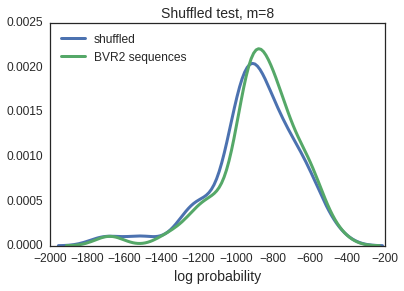

In [42]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

#sns.distplot( bvr1_in_bvr1_log_prob_test_m8, bins=50, hist=False, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1_test"}  );
#sns.distplot( bvr1_shuffled_in_bvr1_log_prob_test_m8, bins=50, hist=False, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR1_test_shuffled"} );
sns.distplot( bvr2_shuffled_in_bvr2_log_prob_test_m8, bins=50, hist=False, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "shuffled"} );
sns.distplot( bvr2_in_bvr2_log_prob_test_m8, bins=50, hist=False, kde=True, rug=False, ax=ax1, axlabel='log probability', kde_kws={"lw": 3, "label": "BVR2 sequences"}  );

ax1.set_title("Shuffled test, m=8",fontsize=14)
#ax1.set_xlim([-1000, -800])
#saveFigure("figures/shuffled-bvr2-m8-new.pdf")

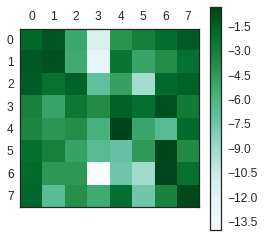

In [78]:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

plt.matshow(swrhmm8_1.dense_transition_matrix()[0:8,0:8], cmap=plt.cm.BuGn); plt.colorbar()

#saveFigure("figures/swrhmm8_1-P.pdf")

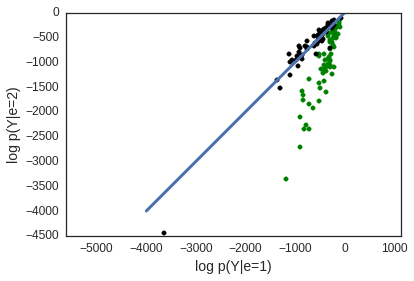

In [96]:
#swr1_in_bvr1_log_prob_test = [ hmm8_1.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]
#swr2_in_bvr2_log_prob_test = [ hmm8_2.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
#swr2_in_bvr1_log_prob_test = [ hmm8_1.log_probability( SWR_test2[a] ) for a in range(len(SWR_test2[:num_sequences])) ]
#swr1_in_bvr2_log_prob_test = [ hmm8_2.log_probability( SWR_test1[a] ) for a in range(len(SWR_test1[:num_sequences])) ]

plt.scatter(swr1_in_bvr1_log_prob_test,swr1_in_bvr2_log_prob_test, color='g')
plt.scatter(swr2_in_bvr1_log_prob_test,swr2_in_bvr2_log_prob_test, color='k')
plt.xlabel('log p(Y|e=1)')
plt.ylabel('log p(Y|e=2)')
plt.axis('equal')
plt.axis([-4500,0,-4500,0])
plt.plot([-4000,0],[-4000,0])


In [149]:
hmm8_1.log_probability( SWR_test2[49])

-365.2141069443752

In [150]:
len(SWR_test2[49])

13

In [129]:
swr2_in_bvr2_log_prob_test

[-4452.482421951776,
 -667.9647937015161,
 -342.9088762016691,
 -674.3325446323652,
 -579.5383462821172,
 -392.49578101675655,
 -930.98182254431,
 -443.6911157655278,
 -256.212585498969,
 -303.12581239611706,
 -444.3631913140602,
 -835.0956885886773,
 -1519.9841523028138,
 -303.95505598017047,
 -156.91462741395472,
 -961.7650703023147,
 -716.6244502074285,
 -212.97143187776715,
 -838.9351653386531,
 -581.1340582541903,
 -244.54772706916478,
 -103.71592817482639,
 -604.7337387373182,
 -488.8922314945012,
 -566.9606798860133,
 -682.4520717596474,
 -369.06189334773717,
 -696.8215030936263,
 -285.25528601165763,
 -287.9647453240742,
 -335.57982741678205,
 -516.775856012898,
 -868.9577849259691,
 -270.43967536095016,
 -219.47737277030134,
 -450.3201888507933,
 -370.93419239609835,
 -344.46572148788266,
 -788.1629425495686,
 -737.8084203980686,
 -877.7744728455854,
 -923.6107010693354,
 -994.5610681783479,
 -962.6609022337194,
 -1349.735685361004,
 -642.9185046716156,
 -338.18160797394387,
 

In [128]:
[x > y+400 for (x,y) in zip(swr2_in_bvr1_log_prob_test,swr2_in_bvr2_log_prob_test) ]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [109]:
5+5

10

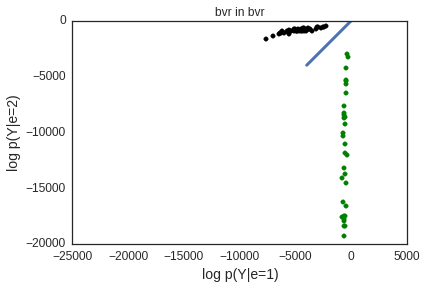

In [117]:
plt.scatter(bvr1_in_bvr1_log_prob_test,bvr1_in_bvr2_log_prob_test, color='g')
plt.scatter(bvr2_in_bvr1_log_prob_test,bvr2_in_bvr2_log_prob_test, color='k')
plt.xlabel('log p(Y|e=1)')
plt.ylabel('log p(Y|e=2)')
plt.axis('equal')
plt.axis([-20000,0,-20000,0])
plt.plot([-4000,0],[-4000,0])
plt.title('bvr in bvr')


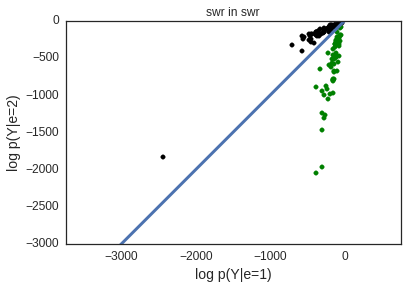

In [103]:
plt.scatter(swr1_in_swr1_log_prob_test,swr1_in_swr2_log_prob_test, color='g')
plt.scatter(swr2_in_swr1_log_prob_test,swr2_in_swr2_log_prob_test, color='k')
plt.xlabel('log p(Y|e=1)')
plt.ylabel('log p(Y|e=2)')
plt.axis('equal')
plt.axis([-3000,0,-3000,0])
plt.plot([-4000,0],[-4000,0])
plt.title('swr in swr')


In [114]:
5+5

10